# Functions to preprocess data
Requires a pandas dataframe as input
Provides a pandas dataframe as output

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

directory = os.getcwd()
data_path = os.path.join(directory, "data")

artists_file = os.path.join(data_path, "artists.dat")
artists_spotify_file = os.path.join(data_path, "data_by_artist_o.csv")
users_artists_file = os.path.join(data_path, "user_artists.dat")

#import data
artist_sp_df = pd.read_csv(artists_spotify_file)
print("artist_sp_df shape: ",artist_sp_df.shape)

artist_df = pd.read_csv(artists_file,sep="\t")
print("artist_df shape: ",artist_df.shape)

weights_df = pd.read_csv(users_artists_file,sep="\t")
print("weights_df shape: ",weights_df.shape)



artist_sp_df shape:  (28680, 16)
artist_df shape:  (17632, 4)
weights_df shape:  (92834, 3)


In [2]:
#remove weights outside of thresholds 
#Avoids issues with uncommon listening habits. 
#i.e: users that have played artist over 100k times
def remove_extreme_weights (df,min_weight,max_weight):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_weight = min # times a user must have played an aritst to keep the record
    max_weight = max # times a user must have played an aritst to keep the record
    '''    
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    bin_data = df.copy()
    labels = ['a.<10','b.10-1K','c.1K-5K','d.5K-10K','e.10K-20K','f.20K-50K','g.50K-100K','h.+100K']
    bins = [0, 10,1000,5000,10000,20000,50000,100000, np.inf]
    bin_data['weight_bin'] = pd.cut(bin_data['weight'], bins,labels=labels)
    print('original data binned:')
    print(bin_data['weight_bin'].value_counts(sort=False))
    print('\n')

    filtered_df = df[df['weight'].between(min_weight, max_weight)].reset_index(drop=True)
    print('df new shape: ',filtered_df.shape)
    sns.boxplot(y="weight", data=filtered_df)
    plt.title('Boxplot - Filtered Data')
    plt.show()
    print('filtered data - stats:')
    print(filtered_df['weight'].describe())
    print('\n')
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")
    
    return filtered_df

df original shape:  (92834, 3)


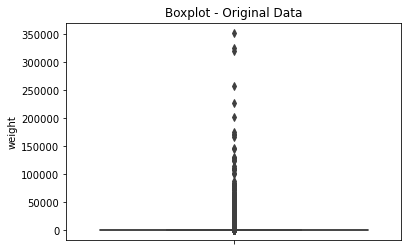

original data binned:
a.<10          3461
b.10-1K       75313
c.1K-5K       12509
d.5K-10K        921
e.10K-20K       380
f.20K-50K       188
g.50K-100K       37
h.+100K          25
Name: weight_bin, dtype: int64


df new shape:  (89545, 3)


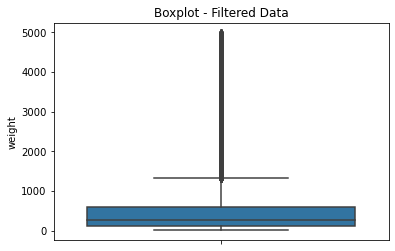

filtered data - stats:
count    89545.000000
mean       509.468792
std        696.317684
min          5.000000
25%        112.000000
50%        260.000000
75%        594.000000
max       4991.000000
Name: weight, dtype: float64


% of removed records: 0.0354


In [3]:
weights_filtered = remove_extreme_weights(weights_df,5,5000)

In [151]:
#source: https://github.com/statisticianinstilettos/recmetrics/blob/master/recmetrics/plots.py 

from matplotlib.lines import Line2D
def long_tail_plot(df, item_id_column, percentage=0.75):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)

    Returns:
    -------
        A long tail plot
    """
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()
    
    #line plot of cumulative volume
    ax=sns.lineplot(x = 'index', y="volume", data=volume_df.reset_index(), color="black")
    #set labels
    ax.set_title('Long Tail Plot of User weights by Artist')
    ax.set_ylabel('# of user weights')
    ax.set_xlabel(item_id_column)
    plt.tick_params(labelbottom = False)
    
    #plot vertical line at the tail location
    head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
    tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
    items_in_head = len(head)
    items_in_tail = len(tail)
    plt.axvline(x=items_in_head, color="red",  linestyle='--')

    # fill area under plot
    head = head.append(tail.head(1))
    x1 = head.index.values
    y1 = head['volume']
    x2 = tail.index.values
    y2 = tail['volume']
    ax.fill_between(x1, y1, color="blue", alpha=0.2)
    ax.fill_between(x2, y2,  color="orange", alpha=0.2)

    #create legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': artists in the head', markerfacecolor='blue', markersize=5),
                       Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': artists in the tail', markerfacecolor='orange', markersize=5)]
    ax.legend(handles=legend_elements, loc=1)

    plt.show()

In [157]:
def remove_popular_artists(df,artist_df,pct_remove):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    pct_remove: pct of top artists to remove. Example: 0.01 removes the top 1% artists with
    top count of users (popular)
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    #input dataset info
    print(f"input data shape: {df.shape}")

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)

    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of tot Users per Artist')
    #plt.ylabel('count of users')
    #plt.show()
    pct_plot = 0.8
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users): ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    threshold = artists_group['count'].quantile(1-pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] > threshold].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Distribution of tot Users per Artist - Filtered Dataset')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',pct_plot)
    
    top_list = artists_group.head(10).index
    print('top 10 artists (most users) - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df

input data shape: (89228, 3)


line divides top: 80.0 % cumulative sum of users:


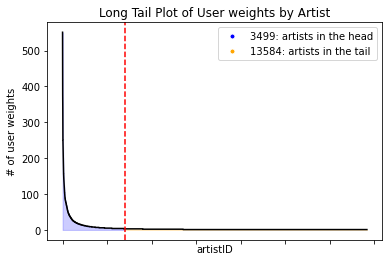

top 10 artists (most users): 
61            Madonna
83          Lady Gaga
148         Radiohead
184              Muse
221       The Beatles
282           Rihanna
283    Britney Spears
289           Beyoncé
294        Katy Perry
327     Avril Lavigne
Name: name, dtype: object


total removed artists: 166


line divides top: 80.0 % cumulative sum of users:


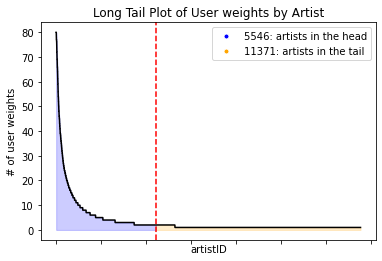

top 10 artists (most users) - filtered dataset: 
52            Goldfrapp
91                Duffy
166             Garbage
185         OneRepublic
259         Céline Dion
315      Jonas Brothers
540      The Ting Tings
799        Rise Against
1034    Boys Like Girls
1177             Sum 41
Name: name, dtype: object


filtered dataset shape: (62107, 3)
% of removed records: 0.304


In [159]:
weights_filtered = remove_popular_artists(weights_for_model,artist_df,0.01)

In [160]:
def remove_rare_artists(df,artist_df,min_users):
    '''
    Requires input dataframe with [userID, artistID, weight] columns
    Requires lastfm artist input dataframe with [id, name] columns
    min_users: minimum number of users each artist must have 
    Dont filter if your algorithm will already take care of this artist-level bias
    '''  
    #input dataset info
    print(f"input data shape: {df.shape}")

    artists_group = df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    pct_plot = 0.8
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(df,'artistID',0.8)
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    print('\n')

    #filter dataset
    #threshold = artists_group['count'].quantile(pct_remove) #percentile
    removed_artists = artists_group[artists_group['count'] < min_users].index
    filtered_df = df[~df['artistID'].isin(removed_artists)].reset_index(drop=True)
    num_removed = len(removed_artists)
    print(f"total removed artists: {num_removed}") 

    #new dataset info
    artists_group = filtered_df.groupby('artistID').agg({'weight': ['count']})
    artists_group = artists_group.droplevel(axis=1, level=0)
    artists_group = artists_group.sort_values(by='count',ascending=False)
    
    #artists_group['artist']=range(0,artists_group.shape[0])
    #ax = sns.lineplot(x = 'artist', y='count', data=artists_group)
    #plt.tick_params(labelbottom = False)
    #plt.title('Long tail distribution of User count by Artist')
    #plt.ylabel('count of users')
    #plt.show()
    print('\n')
    print(f"line divides top: {pct_plot*100} % cumulative sum of users:") 
    long_tail_plot(filtered_df,'artistID',0.8)
    
    top_list = artists_group.tail(10).index
    print('bottom 10 artists - filtered dataset: ')
    print(artist_df[artist_df['id'].isin(top_list)]['name'])
    
    print('\n')
    print(f"filtered dataset shape: {filtered_df.shape}") 
    print(f"% of removed records: {round(1-(filtered_df.shape[0]/df.shape[0]),4)}")


    return filtered_df

input data shape: (62107, 3)


line divides top: 80.0 % cumulative sum of users:


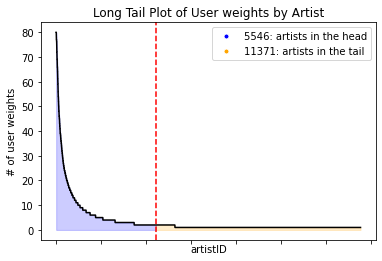

bottom 10 artists: 
9082     Letters From a Tinman
9083                    Fences
9084             Holly Miranda
9085               A.C. Newman
9087                 The Muffs
9089       Sigue Sigue Sputnik
9090              T3CHN0PH0B1A
9091             Ian McCulloch
9092                  Michigan
17631         Grzegorz Tomczak
Name: name, dtype: object


total removed artists: 15036


line divides top: 80.0 % cumulative sum of users:


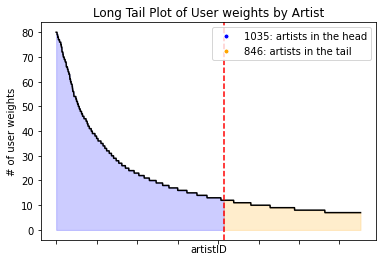

bottom 10 artists - filtered dataset: 
2539          Kajagoogoo
2549                Styx
2564          Rogue Wave
2573             Battles
2578           will.i.am
5353     Blue Foundation
5358           Frou Frou
5365      Kasia Kowalska
5411       Alexis Jordan
12802           Don Omar
Name: name, dtype: object


filtered dataset shape: (37500, 3)
% of removed records: 0.3962


In [206]:
weights_filtered_rare = remove_rare_artists(weights_filtered,artist_df,7)

In [207]:
#remove users with low artist count. 
#Avoid issues if user only listens to 1 artist
def remove_users_lowcount (df,min_artists):
    '''
    Requires input dataframe with userID, artistID, weight columns
    min_artists = minimum number of artists a user must have listened to
    '''    
    print('df original shape: ',df.shape)
    print('unique users: ',df['userID'].nunique())

    grouped_df = df.groupby('userID', dropna=False).agg({'artistID':['count']})
    grouped_df = grouped_df.droplevel(axis=1, level=0)
    users_drop = grouped_df[grouped_df['count'] < min_artists].index

    print(f"users with less than {min_artists} artists: {len(users_drop)}")

    new_df = df[~df['userID'].isin(users_drop)].reset_index(drop=True)

    print('unique users after removal: ',new_df['userID'].nunique())
    print('df new shape: ',new_df.shape)
    print(f"% of removed records: {round(1-(new_df.shape[0]/df.shape[0]),4)}")
    return new_df


In [208]:
weights_for_model = remove_users_lowcount(weights_filtered_rare,10)

df original shape:  (37500, 3)
unique users:  1828
users with less than 10 artists: 90
unique users after removal:  1738
df new shape:  (36959, 3)
% of removed records: 0.0144


In [209]:
#scale weights at user level
#2 users might have a favorite artist, user 1 played such artist 100k times
#user 2 played such artist 10k times. However those users are still neighbors
#dont scale if your algorithm will already take care of this user-level bias

def scale_weight_by_user(df):
    '''
    Requires input dataframe with userID, artistID, weight columns
    Dont scale if your algorithm will already take care of this user-level bias
    '''  
    print('df original shape: ',df.shape)    
    sns.boxplot(y="weight", data=df)
    plt.title('Boxplot - Original Data')
    plt.show()
    
    scaled_df = df.copy()
    scaled_df['weight'] = scaled_df.groupby('userID')['weight'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
    print('df scaled shape: ',scaled_df.shape)    
    sns.boxplot(y="weight", data=scaled_df)
    plt.title('Boxplot - Scaled Data')
    plt.show()
    
    return scaled_df


df original shape:  (36959, 3)


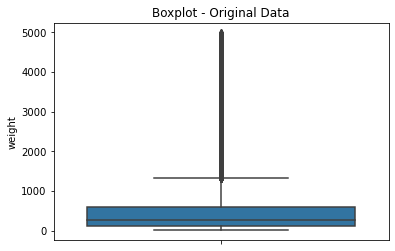

df scaled shape:  (36959, 3)


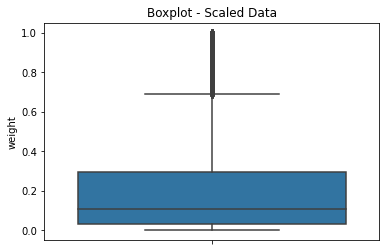

In [210]:
weights_scaled = scale_weight_by_user(weights_for_model)

In [229]:
def train_test_split(df,sample_size,seed=1):
    '''
    Requires input dataframe with userID, artistID, weight columns
    sample_size = number of artists per user to sample for test set
    
    sample_size must be smaller than total artist count per user!!!
    
    '''  
    print(f"input data shape: {df.shape}")
    
    np.random.seed(seed)
    sample = df.groupby('userID').apply(lambda x: x.sample(sample_size))
    sample_index = list(sample.index.get_level_values(1))
 
    train  = df[~df.index.isin(sample_index)]
    train.reset_index(drop=True,inplace=True)
    print(f"train set shape: {train.shape}")

    test  = df[df.index.isin(sample_index)]
    test.reset_index(drop=True,inplace=True)
    print(f"test set shape: {test.shape}")
    print('\n')
    #all test artists must be part of the training data
    unique_train = train['artistID'].unique()
    unique_test = test['artistID'].unique()
    diff = np.setdiff1d(unique_test,unique_train)
    if len(diff)>1:
        print(f"WARNING: {len(diff)} artists from the test set are not on the train set")
        print('1.consider increasing the min count of users per artist when pre-processing')
        print('2.consider decreasing the number of samples per user for train-test split')
        print('3.as al ast resource consider changing your seed')
    else:
        print('OK: all artists from the test set are part on the train set as well')
    return train, test

In [230]:
train, test = train_test_split(weights_scaled,5,2021)

input data shape: (36959, 3)
train set shape: (28269, 3)
test set shape: (8690, 3)


OK: all artists from the test set are part on the train set as well
